Delta Hedging

Backtesting Framework

Author: jimwwwjim

In [37]:
#----packages input---
#for the historical data
from WindPy import *
w.start()
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from math import exp, sqrt, log
from random import seed, gauss
import datetime
from time import clock
from scipy.stats.distributions import norm
import scipy
# pd setting
pd.set_option('display.width',320)
pd.set_option('display.max_rows',100)
# historical data collection and management
# minutes data based on wsi api function

In [38]:
#time structure
contract_enddate = '2019-06-30'
contract_startdate = '2019-05-31'
def time_remain(contract_enddate):
    t_end = datetime.datetime.strptime(contract_enddate,'%Y-%m-%d')
    date_end = t_end.date()
    date_now = datetime.datetime.now().date()
    time_delta = date_end - date_now
    re_days = time_delta.days
    T = re_days/365
    return re_days,T
remain_days, remain_T = time_remain(contract_enddate)
itertype = '1day'
t_start = datetime.datetime.strptime(contract_startdate,'%Y-%m-%d')
t_end = datetime.datetime.strptime(contract_enddate,'%Y-%m-%d')
t_delta = t_end - t_start
print(t_delta)

dt = 0     #相邻节点之间的距离
Niter = 0   #总结点的选择
if itertype == '1day':
    dt = 1/360
    Niter = t_delta.days
    print(Niter)
elif itertype == '30min':
    dt = 1/3000        # waiting for modification
    Niter = t_delta.days*12
elif itertype == '1hour':
    dt = 1/1500       # waiting for modification
    Niter = t_delta.days*6

30 days, 0:00:00
30


 First part of backtest based on the prices simulated by stochastic process

In [39]:
def MonteCarlo(reTime, rf, S, K, sigma):
	reTime = Niter
	siTi = 100000
	list_1 = []   #asian call option value list
	list_2 = []   #asian put option value list
	dt = 1/250
	totalNodes = reTime
	for si in range(siTi):
		path = [S]
		for node in range(int(totalNodes)-1):
			path.append(path[-1]*exp((rf-0.5*sigma**2)*dt+(sigma*sqrt(dt)*gauss(0,1))))
		ave_close = average(path)
		asian_put_value = max(K-ave_close,0)
		asian_call_value = max(ave_close-K,0)
		list_2.append(asian_put_value)
		list_1.append(asian_call_value)
	p = sum(list_2)/siTi
	c = sum(list_1)/siTi
	#return {'asianput_MC':p,'asiancall_MC':c,'asiandelta':delta,'asian_gamma':gamma}
	return {'asianput_MC':p,'asiancall_MC':c}

In [5]:
timer_ = clock()
print(MonteCarlo(28,.03,12030,12030,.3),clock()-timer_)

{'asianput_MC': 268.1289101995841, 'asiancall_MC': 292.45223897545765} 6.0477618


In [33]:
def BlackScholes(reTime, rf, S, K, sigma):
	reTime = reTime/360
	d1=(log(S/K)+(rf+sigma**2/2)*reTime)/sigma*sqrt(reTime)
	d2=d1-sigma*sqrt(reTime)
	call_BS = (S*norm.cdf(d1,0,1)-K*exp(-rf*reTime)*norm.cdf(d2,0,1))
	put_BS = K*exp(-rf*reTime)*norm.cdf(-d2,0,1)-S*norm.cdf(-d1,0,1)
	delta=norm.cdf(d1,0,1)
	gamma=norm.pdf(d1,0,1)/(S*sigma*sqrt(reTime))
	vega=S*norm.pdf(d1)*np.sqrt(reTime)
	theta=-.5*S*norm.pdf(d1)*sigma/np.sqrt(reTime)
	return {'call_BS':call_BS,'put_BS':put_BS,'delta':delta,'gamma':gamma,'vega':vega,'theta':theta}

In [34]:
tiemr_ = clock()
bsvalue = BlackScholes(120,.03,1940,1940,.15)
print(bsvalue['put_BS'],clock()-tiemr_)

57.090855798104826 0.0014095999977143947


In [42]:
def MonteCarlo_2(reTime,rf,S,K,sigma): #special for price insurance
	reTime = Niter
	siTi = 10
	list_1 = []   #asian call option value list
	list_2 = []   #asian put option value list
	dt = 1/360
	totalNodes = reTime
	for si in range(siTi):
		path = [S]
		for node in range(int(totalNodes)-1):
			path.append(path[-1]*exp((rf-0.5*sigma**2)*dt+(sigma*sqrt(dt)*gauss(0,1))))     
		ave_close = average(path[-30:])
		asian_put_value = max(K-ave_close,0)
		asian_call_value = max(ave_close-K,0)
		list_2.append(asian_put_value)
		list_1.append(asian_call_value)
	p = sum(list_2)/siTi
	c = sum(list_1)/siTi
	#return {'asianput_MC':p,'asiancall_MC':c,'asiandelta':delta,'asian_gamma':gamma}
	return {'asianput_MC':p,'asiancall_MC':c}

In [43]:
timer_ = clock()
trial_ = MonteCarlo_2(120,.03,1940,1940,.14)
print(trial_['asianput_MC'],clock()-timer_)

19.769692446502745 0.0016089999990072101


In [6]:
def asian_delta(reTime, rf, S, K, sigma):
	MC_1 = MonteCarlo(reTime, rf, S*(1+0.01*sigma), K, sigma)
	MC_2 = MonteCarlo(reTime, rf, S*(1-0.01*sigma), K, sigma)
	putvalue_1 = MC_1['asianput_MC']
	putvalue_2 = MC_2['asianput_MC']
	delta = (putvalue_1-putvalue_2)/(0.02*sigma*S)
	return delta
def asian_gamma(reTime, rf, S, K, sigma):
	S1 = S + 0.01*S
	S2 = S - 0.01*S
	ad_1 = asian_delta(reTime, rf, S1, K, sigma)
	ad_2 = asian_delta(reTime, rf, S2, K, sigma)
	gamma = (ad_1 - ad_2)/(0.02*S)
	return gamma

def asian_theta(reTime,rf,S,K,sigma):
	tau_1 = reTime-dt
	MC_1 = MonteCarlo(tau_1, rf, S, K, sigma)
	MC_2 = MonteCarlo(reTime, rf, S, K, sigma)
	putvalue_1 = MC_1['asianput_MC']
	putvalue_2 = MC_2['asianput_MC']
	theta = (putvalue_2-putvalue_1)/dt
	return theta

In [7]:
def BS_delta(reTime,rf,S,K,sigma):
    return norm.cdf((log(S/K)+(rf+sigma**2/2)*reTime*dt)/sigma*sqrt(reTime*dt),0,1)

Delta check

80.88534980429947 0.0004250999991199933


In [4]:
class MCAPut(object):
	def __init__(self,start,T,K,N):
		self.T=T
		self.K=K
		self.start=start  #time to sell option
		self.N=N
		
	def calc(self,today,sigma,S,rf):
		if today<self.start:
			return {'asian_delta':0,'asian_put':0,'asian_gamma':0,'asian_theta':0,'theta':0}
		if today>self.T:
			return {'asian_delta':0,'asian_put':0,'asian_gamma':0,'asian_theta':0,'theta':0}
		if today == self.T:
			return {'asian_delta':0,'asian_put':0,'asian_gamma':0,'asian_theta':0,'theta':0}
		reTime=(self.T-today)/250.
		#print('class MCAPut self.T',self.T)
		#print('class MCAPut today',today
		#reTime=(self.T-today)/3000
		#print('class MCAPut reTime',reTime)
		asian_put = MonteCarlo(reTime, rf, S, self.K, sigma)['asianput_MC']
		delta = asian_delta(reTime, rf, S, self.K, sigma)
		print('delta:',delta)
		#print(type(delta))
		gamma = asian_gamma(reTime, rf, S, self.K, sigma)
		print('gamma:',gamma)
		#print(type(gamma))
		theta = asian_theta(reTime, rf, S, self.K, sigma)
		print('theta:',theta)
		#print(type(theta))
		return{'asian_delta':self.N*delta,'asian_put':self.N*asian_put,'asian_gamma':self.N*gamma,'asian_theta':self.N*theta}


In [9]:
asian = MCAPut(10,100,12000,-10)

In [10]:
asian.calc(10,0.3,12000,.03)

delta: 0.0
gamma: 0.0
theta: 0.0


{'asian_delta': -0.0,
 'asian_gamma': -0.0,
 'asian_put': -115000.0,
 'asian_theta': -0.0}

In [18]:
w = gauss(0,1)
print(w)
for i in range(10):
    a = 2 * gauss(0,1)
    print(a)

-0.6704671385149735
3.852036906977588
-1.8689417003134678
0.9270011080407748
-0.6925409309934337
2.34748199991304
-1.1752420513761221
4.268445947788181
3.0101215873138782
1.0922565034231524
0.5868020482477577


In [31]:
def deltahedge_1(Niter,Sdynamics='S*=(1.0+vol*sqrt(dt)*gauss(0,1))',sigmaDynamics='sigma=.3'):
	#optiontype = 'asian'     # optiontype could be: asian, european
	#pcflag = 'put'           # pcflag could be call or put
	global dt
	dt = 1/250
	    
	S = 12000
	Strike = 12000
	rf = .03
	sigma = .3
	cash = 0
	#original code is dt = 1/250, in a daily basis, but in this case, each iteration means 30 mins)
	# dt is defintly required
	iterToSell = 1
	iterMaturity = Niter-1
	asianput = MCAPut(iterToSell,iterMaturity,Strike,-10)
	# just for now setting
	S_list = []
	'''
	-----------------------------------------------------------------
	only if the other type of option is using this framework
	-----------------------------------------------------------------
	
	if optiontype == 'asian':
		columns = {'spot','vol','ZSS','cash','asian_put','totalValue','delta','gamma','ww','comm','pnlPredict'}
		df = pd.DataFrame([[S,vol,0,0,0,0,0,0,0,0,0]],columns=columns)
		if pcflag == 'put':
			put = MCAPut(iterToSell,iterMaturity,Strike,-10)
		elif pcflag == 'call':
			print('this is not good yet')
		else:
			print('pcflag is needed')
	elif optiontype == 'european':
		columns=('spot','vol','ZSS','cash','option','call_BS','vega','gamma','theta','comm','pnlPredict')
		df = pd.DataFrame([[S,vol,0,0,0,0,0,0,0,0,0]],columns=columns)
		if pcflag == 'call':
			call = BSCall(iterToSell,iterMaturity,Strike,-10)
		elif pcflag == 'put':
			print('this function is not available yet')
		else:
			print('pcfalg is needed')
	'''
	columns = {'spot','vol','ZSS','cash','asian_put','totalValue','delta','gamma','ww','comm','pnlPredict'}
	df = pd.DataFrame([[S,sigma,0,0,0,0,0,0,0,0,0]],columns=columns)
	put = MCAPut(iterToSell,iterMaturity,Strike,-10)

	for iter in range(1,Niter+1):
		#exec(Sdynamics)
		#exec(sigmaDynamics)
		
		
		S*=exp(rf*dt+sigma*sqrt(dt)*gauss(0,1))
		S_list.append(S)
		asianPutValue = asianput.calc(iter,sigma,S,rf)
		
		if iter == iterToSell:     # sell the put
			#asianPutValue = asianput.calc(iter,vol,S,rf)
			cash-=asianPutValue['asian_put']
			#print(asianPutValue['asian_put'])
		
		#delta hedging
		
		asianPutValue=asianput.calc(iter,sigma,S,rf)
		#print(asianPutValue)
		delta = asianPutValue['asian_delta']
		#delta = 0
		#print(delta)
		currentNumberContracts=df.iloc[iter-1].ZSS
		contractsBuy=-currentNumberContracts-delta
		cash-=contractsBuy*S
		
		#comm could be ZSS*rate or contratsBuy*rate
		
		if iter==iterMaturity:
			cash+=max(Strike-(sum(S_list)/len(S_list)),0)     #settle asian put, directly calculate the intrincsic value
		
		gamma = asianPutValue['asian_gamma']
		print('gamma:',gamma)
		theta = asianPutValue['asian_theta']
		print('theta:',theta)
		lambda_1 = 0.03                #trading cost at percentage
		comm = contractsBuy*S*lambda_1      #commision fee
		print('comm:',comm)
		ww = (1.5*exp(-rf*dt)*S*lambda_1*gamma**2)**(1/3)
		print('ww',ww)
		# based on the formula of whalley wilmott, 风险厌恶系数取1
		
		
		
		dS=S-df.iloc[iter-1].spot
		pnlPredict=0.5*gamma*dS*dS+theta*dt    # 是否成立还需要再论证
		dfnew = pd.DataFrame([[S,sigma,-delta,cash,-asianPutValue['asian_put'],cash+asianPutValue['asian_put']-delta*S,delta,gamma,ww,comm,pnlPredict]],columns=columns)
		df=df.append(dfnew,ignore_index=True)
		
	df['pnl'] = df['asian_put'] - df['asian_put'].shift(1)
	df['vol'] = 100.0*df['vol']
	df['error'] = df['pnl'] - df['pnlPredict']
	df.set_value(iterToSell,'error',0)
	
	
	#data visualization
	df.loc[:,['vol','spot']].plot(title='spot and implied volatility')
	df.loc[:,['asian_put','spot','option']].plot(title='i dont know what it is')
	df.loc[:,['delta']].plot(title='delta {0} {1}'.format(Sdynamics,sigmaDynamics))
	df.loc[:,['gamma']].plot(title='Gamma {0} {1}'.format(Sdynamics,sigmaDynamics))
	df.loc[:,['ww']].plot(title='ww value {0} {1}'.format(Sdynamics,sigmaDynamics))
	df.loc[:,['pnl']].hist(bins=50)
	print(df.loc[:,['pnl']].describe())
	print(df.head())



gamma: -0.0
theta: -0.0
comm: -4282044.689127154
ww 0.0
gamma: -0.0
theta: -0.0
comm: -4243932.083292693
ww 0.0
gamma: -0.0
theta: -0.0
comm: -4264086.013805233
ww 0.0
gamma: -0.0
theta: -0.0
comm: -4283260.845824047
ww 0.0
gamma: -0.0
theta: -0.0
comm: -4271435.834845482
ww 0.0
gamma: -0.0
theta: -0.0
comm: -4251816.1231335085
ww 0.0
gamma: -0.0
theta: -0.0
comm: -4240972.782949461
ww 0.0
gamma: -0.0
theta: -0.0
comm: -4213901.103736465
ww 0.0
gamma: -0.0
theta: -0.0
comm: -4169258.335902829
ww 0.0
gamma: -0.0
theta: -0.0
comm: -4164251.689282616
ww 0.0
gamma: -0.0
theta: -0.0
comm: -4219023.558772269
ww 0.0
gamma: -0.0
theta: -0.0
comm: -4272292.970826942
ww 0.0
gamma: -0.0
theta: -0.0
comm: -4265520.285324074
ww 0.0
gamma: -0.0
theta: -0.0
comm: -4200374.493172698
ww 0.0
gamma: -0.0
theta: -0.0
comm: -4145882.53497884
ww 0.0
gamma: -0.0
theta: -0.0
comm: -4165940.434123369
ww 0.0
gamma: -0.0
theta: -0.0
comm: -4206176.7191111
ww 0.0
gamma: -0.0
theta: -0.0
comm: -4233038.941237622
w

C:\Users\49912\Anaconda3\lib\site-packages\ipykernel_launcher.py:95: FutureWarning: set_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
C:\Users\49912\Anaconda3\lib\site-packages\ipykernel_launcher.py:100: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
C:\Users\49912\Anaconda3\lib\site-packages\pandas\core\indexing.py:1367: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  return self._getitem_tuple(key)


        pnl
count  30.0
mean    0.0
std     0.0
min     0.0
25%     0.0
50%     0.0
75%     0.0
max     0.0
            ZSS  asian_put  vol         gamma  pnlPredict         delta  spot  totalValue   ww          cash  comm  pnl     error
0  12000.000000        0.3  0.0  0.000000e+00         0.0  0.000000e+00   0.0         0.0  0.0  0.000000e+00   0.0  NaN       NaN
1  11894.568581        0.3  0.0  1.428498e+08    115000.0  1.427348e+08  -0.0        -0.0  0.0 -4.282045e+06  -0.0  0.0       0.0
2  11893.193252        0.3  0.0  2.843142e+08    115000.0  2.841992e+08  -0.0        -0.0  0.0 -4.243932e+06  -0.0  0.0 -115000.0
3  11951.054477        0.3  0.0  4.264504e+08    115000.0  4.263354e+08  -0.0        -0.0  0.0 -4.264086e+06  -0.0  0.0 -115000.0
4  11946.674814        0.3  0.0  5.692258e+08    115000.0  5.691108e+08  -0.0        -0.0  0.0 -4.283261e+06  -0.0  0.0 -115000.0


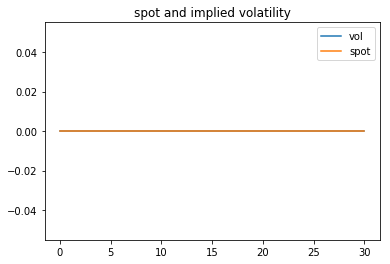

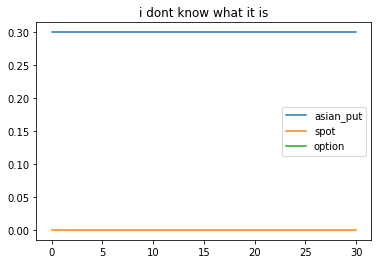

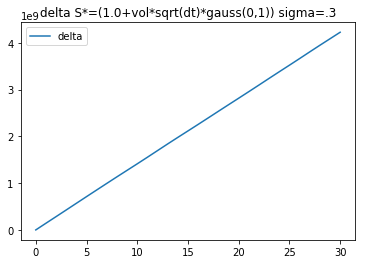

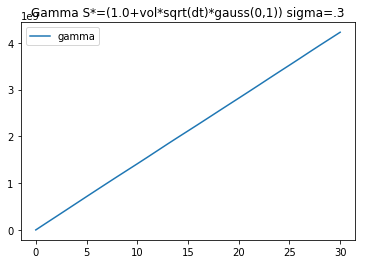

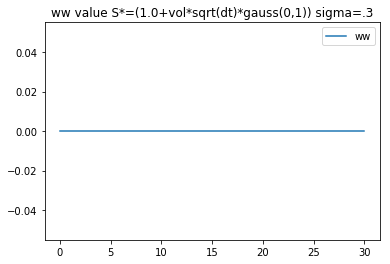

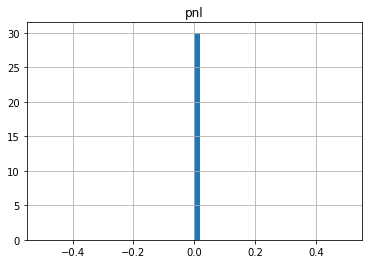

In [27]:
deltahedge_1(Niter)

Second part of backtest based on the prices generated from Wind Terminal

In [35]:
itertype = '1day'     #frequency of detecting and hedging
if itertype == '30min':
    startdate = '2019-05-31 09:00:00'
    enddate = '2019-06-06 15:00:00'
    expired_data = '2019-06-31 15:00:00'
    wdata = w.wsi("RU1909.SHF", "close", startdate, enddate, "BarSize=30")
elif itertype == '1hour':
    startdate = '2019-05-31 09:00:00'
    enddate = '2019-06-06 15:00:00'
    expired_data = '2019-06-31 15:00:00'
    wdata = w.wsi("RU1909.SHF", "close", startdate, enddate, "BarSize=60")
elif itertype == '1day':
    startdate = '2019-03-31'
    enddate = '2019-06-06'
    expired_data = '2019-06-31'
    wdata = w.wsd("RU1909.SHF", "close", startdate, enddate, "")
    
prices_data = wdata.Data[0]
times_data = wdata.Times
Niter = len(prices_data)
original_data = pd.DataFrame({'prices':prices_data,'timestamp':times_data})
print(original_data)
#print(wsi_data)
#print(wsi_data.Data)
#print(wsi_data.Times)

     prices   timestamp
0   11715.0  2019-04-01
1   11680.0  2019-04-02
2   11770.0  2019-04-03
3   11795.0  2019-04-04
4   11835.0  2019-04-08
5   11700.0  2019-04-09
6   11955.0  2019-04-10
7   11910.0  2019-04-11
8   11930.0  2019-04-12
9   11840.0  2019-04-15
10  11685.0  2019-04-16
11  11645.0  2019-04-17
12  11400.0  2019-04-18
13  11470.0  2019-04-19
14  11480.0  2019-04-22
15  11540.0  2019-04-23
16  11475.0  2019-04-24
17  11495.0  2019-04-25
18  11270.0  2019-04-26
19  11255.0  2019-04-29
20  11700.0  2019-04-30
21  11665.0  2019-05-06
22  11865.0  2019-05-07
23  11845.0  2019-05-08
24  11790.0  2019-05-09
25  11775.0  2019-05-10
26  11905.0  2019-05-13
27  11540.0  2019-05-14
28  11745.0  2019-05-15
29  12250.0  2019-05-16
30  12205.0  2019-05-17
31  12045.0  2019-05-20
32  12375.0  2019-05-21
33  11905.0  2019-05-22
34  11720.0  2019-05-23
35  11850.0  2019-05-24
36  11860.0  2019-05-27
37  11955.0  2019-05-28
38  12205.0  2019-05-29
39  12030.0  2019-05-30
40  12250.0  201

In [36]:
def deltahedge_2(Niter):
    timer_1 = clock()
    Strike = 12000
    rf = .03
    vol = .3
    Strike = 12250
    iterToSell = 1
    iterMaturity = Niter-1
    for i in range(Niter):
        S = original_data['prices'][i]
        print(S)
            
        #asianput = MCAPut(iterToSell,iterMaturity,Strike,-10)
        #asianPutValue = asianput.calc(iter,vol,S,rf)
    timer_2 = clock()
    print('deltahedge_2 time spent:',timer_2 - timer_1)
    

In [37]:
deltahedge_2(Niter)

11715.0
11680.0
11770.0
11795.0
11835.0
11700.0
11955.0
11910.0
11930.0
11840.0
11685.0
11645.0
11400.0
11470.0
11480.0
11540.0
11475.0
11495.0
11270.0
11255.0
11700.0
11665.0
11865.0
11845.0
11790.0
11775.0
11905.0
11540.0
11745.0
12250.0
12205.0
12045.0
12375.0
11905.0
11720.0
11850.0
11860.0
11955.0
12205.0
12030.0
12250.0
11900.0
11910.0
12125.0
12235.0
deltahedge_2 time spent: 0.005334699999366421
